## 1. Import Packages and Dataset 

In [11]:
import pandas as pd
import numpy as np
import sklearn
import torch.nn as nn
import sklearn.model_selection
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

In [12]:
def add_target(team):
    team['target'] = team['won'].shift(-1)
    return team

def rest_days(team):
    team['date_time'] = pd.to_datetime(team['date'])
    team['rest'] = (team['date_time'] - team['date_time'].shift(1)).dt.days
    team['rest'] = team['rest'].fillna(0)
    team['rest'] = team['rest'].astype(int)
    del team['date_time']
    return team

def winrate(team):
    total = team['Wins'] + team['Losses']
    total_opp = team['Wins_opp'] + team['Losses_opp']
    team['winrate'] = team['Wins'] / total
    team['winrate_opp'] = team['Wins_opp'] / total_opp
    return team

def differential(team):
    team['differential'] = team['Total'] - team['Total_opp']
    return team

def find_team_exp_average_5(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.ewm(span=5, adjust=False).mean()
    return rolling

def find_team_exp_average_9(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.ewm(span=9, adjust=False).mean()
    return rolling

def find_team_exp_average_12(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.ewm(span=12, adjust=False).mean()
    return rolling

def find_team_average_15(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.rolling(15).mean()
    return rolling

def find_team_average_10(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.rolling(10).mean()
    return rolling

def find_team_average_5(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.rolling(5).mean()
    return rolling

def find_team_average_3(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.rolling(3).mean()
    return rolling

def rolling(data):
    df_rolling_3 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_3 = df_rolling_3.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_3)
    df_rolling_5 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_5 = df_rolling_5.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_5)
    df_rolling_10 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_10 = df_rolling_10.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_10)
    df_rolling_15 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_15 = df_rolling_15.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_15)
    df_exp_rolling_5 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_exp_rolling_5 = df_exp_rolling_5.groupby(['Teams', 'season'], group_keys = False).apply(find_team_exp_average_5)
    df_exp_rolling_9 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_exp_rolling_9 = df_exp_rolling_9.groupby(['Teams', 'season'], group_keys = False).apply(find_team_exp_average_9)
    df_exp_rolling_12 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_exp_rolling_12 = df_exp_rolling_12.groupby(['Teams', 'season'], group_keys = False).apply(find_team_exp_average_12)
    exp_rolling_columns_5 = [f"{col}_exp_5" for col in df_exp_rolling_5.columns]
    exp_rolling_columns_9 = [f"{col}_exp_9" for col in df_exp_rolling_9.columns]
    exp_rolling_columns_12 = [f"{col}_exp_12" for col in df_exp_rolling_12.columns]
    rolling_columns_15 = [f"{col}_15" for col in df_rolling_15.columns]
    rolling_columns_10 = [f"{col}_10" for col in df_rolling_10.columns]
    rolling_columns_5 = [f"{col}_5" for col in df_rolling_5.columns]
    rolling_columns_3 = [f"{col}_3" for col in df_rolling_3.columns]
    df_exp_rolling_12.columns = exp_rolling_columns_12
    df_exp_rolling_9.columns = exp_rolling_columns_9
    df_exp_rolling_5.columns = exp_rolling_columns_5
    df_rolling_15.columns = rolling_columns_15
    df_rolling_10.columns = rolling_columns_10
    df_rolling_5.columns = rolling_columns_5
    df_rolling_3.columns = rolling_columns_3
    df = pd.concat([data, df_rolling_3, df_rolling_5, df_rolling_10, df_rolling_15, df_exp_rolling_5,df_exp_rolling_9, df_exp_rolling_12], axis=1)
    # df_exp_rolling_5,df_exp_rolling_9, df_exp_rolling_12
    return df

def ratio(feature):
    feature_opp = 'OPP_' + str(feature)
    free = nba[feature] / nba[feature_opp]
    return free

def ratios(nba):
    regard = []
    disregard = [col for col in nba.columns if "OPP_" in col]
    for col in disregard:
        col = col[4:100]
        if col in nba.columns:
            regard.append(col)
    nba_ratio = nba[regard].apply(ratio)
    nba_ratios_columns = [f"{col}_ratio" for col in nba_ratio.columns]
    nba_ratio.columns
    return regard

def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_col(df, col_name):
    return df.groupby("Teams", group_keys=False).apply(lambda x: shift_col(x, col_name))

def date_change(datetime_str):
    # Parse the datetime string into a datetime object
    datetime_obj = datetime.strptime(datetime_str, '%m/%d/%Y')

    # Format the datetime object into a new string structure
    new_datetime_str = datetime_obj.strftime('%Y-%m-%d')

    return new_datetime_str

def haircut(df, date):
    df[date] = df[date].str[:10]
    return df

def convert_date_format(df):
    # Create a boolean mask to identify values in the "m/d/y" format
    mask = df['Date'].str.contains(r'\d{1,2}/\d{1,2}/\d{2}')
    
    # Apply the conversion only to values that match the mask
    df.loc[mask, 'Date'] = nba.loc[mask, 'Date'].apply(date_change)
    return df

def spread(df):
    # construct spread between home and away rankings
    ranks = [i for i in df.columns if 'RANK' in i]
    ranks_home = [i for i in ranks if '_x' in i]
    ranks_away = [i for i in ranks if '_y' in i]
    spread_columns_names = [col[:-1] for col in ranks_home]
    
    spread_columns = []
    for base_name in spread_columns_names:
        spread_column = df[f'{base_name}x'] - df[f'{base_name}y']
        spread_column.name = f'{base_name}spread'
        spread_columns.append(spread_column)
        
    spread_df = pd.concat(spread_columns, axis=1)
    return spread_df

def last_season(df):
    # construct winrate from last season
    df['last_season_winrate'] = df.groupby('Teams', 'season')['winrate'].last()

In [13]:
!pwd

/Users/benjamincheng/Documents/GitHub/Sports-Betting/ml_notebooks/models


In [14]:
folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/data/raw_data/NBA_2018_2024.csv"
#folder_path = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/data/raw_data/NBA_2018_2024.csv"

df = pd.read_csv(folder_path, index_col=0)

folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/nba_api/data/teams_stats/processed_cumulative_season_stats_2019_2024.csv"
#folder_path = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/nba_api/data/teams_stats/processed_cumulative_season_stats_2019_2024.csv"
nba = pd.read_csv(folder_path, index_col=0)

folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/data/odds_data/2021_01_20_onward.csv"
#folder_path = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/data/odds_data/2021_01_20_onward.csv"
odds = pd.read_csv(folder_path, index_col=0)

In [15]:
# nba dataframe does not include the 2018 season
df = df[~df['season'].isin([2018])]
df = df.reset_index(drop=True)
df = haircut(df, 'date')

# rename nba columns to match df
nba = haircut(nba, 'Date')
nba = convert_date_format(nba)
nba.rename(columns={'Date': 'date'}, inplace=True)

#rename odds columns to match df
odds.rename(columns={'Timestamp': 'date_next'}, inplace=True)

# construct winrate for team
df = winrate(df)
# construct differential points
df = differential(df)
# construct target
df = df.groupby("Teams", group_keys=False).apply(add_target)
# construct resting
df = df.groupby(["Teams",'season'], group_keys=False).apply(rest_days)
# games yet to play are 2
df.loc[pd.isnull(df['target']), 'target'] = 2
# convert win/loss to 1/0
df['target'] = df['target'].astype(int)

# remove metadata and target for df
removed = ['target', 'date', 'Teams_opp', 'Teams',
           'season','won', 'Wins', 'Losses', 
           'Wins_opp', 'Losses_opp']
valid_columns = df.columns[~df.columns.isin(removed)]

# scale the data for df
scaler = MinMaxScaler()
df[valid_columns] = scaler.fit_transform(df[valid_columns])

# construct rolling features to df
df = rolling(df).copy()
df = df.dropna()

# remove metadata for nba ranking 
removed = ['date', 'Teams']
valid_columns = nba.columns[~nba.columns.isin(removed)]

# scale the ranking data
scaler = MinMaxScaler()
nba[valid_columns] = scaler.fit_transform(nba[valid_columns])

# remove metadata for odds data
# removed = list(odds.columns[odds.dtypes == 'object'])
# valid_columns = odds.columns[~nba.columns.isin(removed)]

# scale the odds data
# scaler = MinMaxScaler()
# odds[valid_columns] = scaler.fit_transform(odds[valid_columns])

# construct current game metadata for df
df['home_next'] = add_col(df, 'home')
df['team_next_opp'] = add_col(df, 'Teams_opp')
df['date_next'] = add_col(df, 'date')
df = df.copy()

# merge stats from nba dataframe
full = pd.merge(df, nba, on=['Teams', 'date'], how='left')
full = full.dropna()

# merge stats from opposing teams
complete = full.merge(full,
               left_on=['Teams', 'date_next'],
               right_on = ['team_next_opp', 'date_next'])

# concat the spreads
spread_df = spread(complete)
complete = pd.concat([complete, spread_df], axis=1)

# concat the odds
complete = pd.merge(complete, odds, on=['Teams_x', 'date_next', 'Teams_y'], how='left')
complete = complete.dropna()

/var/folders/99/zv3w4flx1598dxlknc099kfr0000gn/T/ipykernel_61611/833364530.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Teams", group_keys=False).apply(add_target)
/var/folders/99/zv3w4flx1598dxlknc099kfr0000gn/T/ipykernel_61611/833364530.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["Teams",'season'], group_keys=False).apply(rest_days)
/var/folders/99/zv3w4f

In [16]:
complete_cleaning = complete.copy()
# Dropping duplicated columns
complete_cleaning = complete_cleaning.T.drop_duplicates(keep='first').T
for column in complete_cleaning.columns:
    complete_cleaning[column] = pd.to_numeric(complete_cleaning[column], errors='ignore')
# remove metadata and useless data
disregard = list(complete_cleaning.columns[complete_cleaning.dtypes == 'object']) 
# disregard = disregard + ["target_x","target_y"]
# Temporary change for tuning

disregard = disregard + ["target_y", "target_x"]
regard = complete_cleaning.columns[~complete_cleaning.columns.isin(disregard)]

/var/folders/99/zv3w4flx1598dxlknc099kfr0000gn/T/ipykernel_61611/1933320601.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  complete_cleaning[column] = pd.to_numeric(complete_cleaning[column], errors='ignore')


In [17]:
# want to exclude January 2024 - March 2024 data from dataframe to use for out of sample testing
complete_cleaning = complete_cleaning[~complete_cleaning['date_next'].str.contains('2024-03')|complete_cleaning['date_next'].str.contains('2024-02')|complete_cleaning['date_next'].str.contains('2024-01')]
complete_cleaning = complete_cleaning.reset_index(drop=True)

In [20]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier

rr = RidgeClassifier(alpha=1)
split = TimeSeriesSplit(n_splits=3)

# can also try direction backward
sfs = SequentialFeatureSelector(rr, n_features_to_select = 70, direction='forward', cv=split)
sfs.fit(complete_cleaning[regard], complete_cleaning['target_x'])
predictors = list(regard[sfs.get_support()])
predictors

['usg%_x',
 'orbmaxes_x',
 'orb%maxes_x',
 'ast%maxes_opp_x',
 'ft_3_x',
 'fta_3_x',
 'ft%maxes_3_x',
 'blkmaxes_3_x',
 'tov%maxes_5_x',
 'ft%maxes_10_x',
 'ast_opp_10_x',
 'stl_opp_10_x',
 'stlmaxes_opp_10_x',
 'ft%maxes_15_x',
 'ftrmaxes_opp_15_x',
 'stl%maxes_opp_15_x',
 'mp_exp_5_x',
 'astmaxes_opp_exp_5_x',
 '+/-maxes_opp_exp_5_x',
 'mp_exp_9_x',
 'fgamaxes_exp_9_x',
 'ft%maxes_exp_9_x',
 'astmaxes_opp_exp_9_x',
 'ortgmaxes_opp_exp_9_x',
 'mp_exp_12_x',
 'ft%maxes_exp_12_x',
 'astmaxes_opp_exp_12_x',
 'GP_base_x',
 'MIN_base_x',
 'FGA_base_x',
 'REB_base_x',
 'OPP_PTS_FB_RANK_misc_x',
 '3p%maxes_y',
 'ts%maxes_y',
 'usg%maxes_opp_y',
 'differential_y',
 'ft%maxes_3_y',
 'FT/FGA_3_y',
 '3pmaxes_opp_3_y',
 'astmaxes_opp_3_y',
 'stl%maxes_opp_3_y',
 'ts%_5_y',
 'efg%_5_y',
 'stl%maxes_opp_5_y',
 'mp_10_y',
 'ft%maxes_10_y',
 'stlmaxes_opp_10_y',
 'stl%maxes_opp_10_y',
 'ortgmaxes_opp_10_y',
 'ft%maxes_15_y',
 '+/-maxes_opp_15_y',
 'ftrmaxes_opp_15_y',
 'stl%maxes_opp_15_y',
 'rest_15

## Calibration Model

-----------------------------------Fold 1-----------------------------------
The uncalibrated model scoring: 
The roc_auc score is:0.7304282086890783
The brier score is:0.21086431211991694
The calibrated model scoring: 
The roc_auc score is:0.7275445862402384
The brier score is:0.21170426314345556


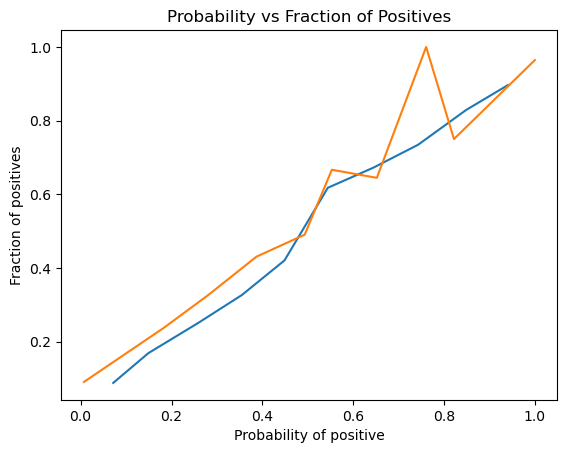

-----------------------------------Fold 2-----------------------------------
The uncalibrated model scoring: 
The roc_auc score is:0.7093819504552377
The brier score is:0.21773063715211513
The calibrated model scoring: 
The roc_auc score is:0.704631673806576
The brier score is:0.2179457910889249


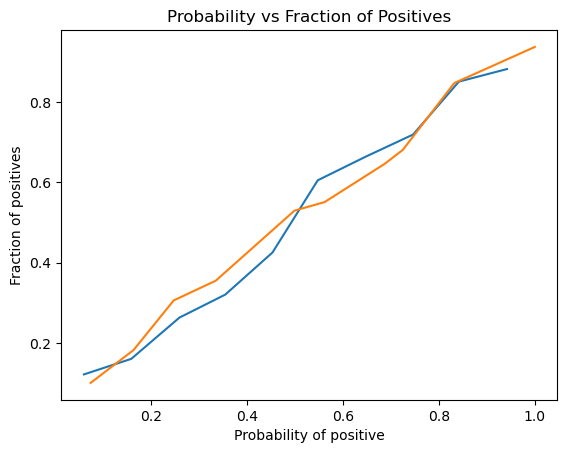

-----------------------------------Fold 3-----------------------------------
The uncalibrated model scoring: 
The roc_auc score is:0.7493145431885726
The brier score is:0.20519288450818518
The calibrated model scoring: 
The roc_auc score is:0.7488078118794255
The brier score is:0.203205168051807


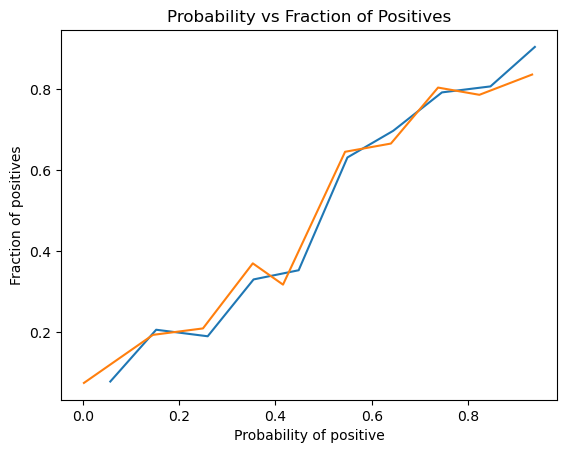

In [48]:
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve 
import seaborn as sns
X = complete_cleaning[predictors]
y = complete_cleaning['target_x']

best_brier_score = float('inf')
best_model = None
fold = 0

clf = LogisticRegression(penalty='l2', C=1.0, max_iter=1000)
test_size = len(y) // 4

tscv = TimeSeriesSplit(n_splits=3, test_size=test_size)
fold = 0
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # include a validation set for calibration
    split_index = int(len(X_train) * 0.8)  # 80% training, 20% validation
    X_train_split, X_val = X_train.iloc[:split_index], X_train.iloc[split_index:]
    y_train_split, y_val = y_train.iloc[:split_index], y_train.iloc[split_index:]
    
    fold += 1 
    
    clf.fit(X_train_split, y_train_split)
    y_pred = clf.predict_proba(X_test)[:, 1]
    
    print(f'-----------------------------------Fold {fold}-----------------------------------')
    print('The uncalibrated model scoring: ')
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f'The roc_auc score is:{roc_auc}')
    brier = brier_score_loss(y_test, y_pred)
    print(f'The brier score is:{brier}')
    
    frac_of_positives, pred_prob = calibration_curve(y_test, y_pred, n_bins=10)
    sns.lineplot(x=pred_prob, y=frac_of_positives)
    plt.title("Probability vs Fraction of Positives")
    xlabel = plt.xlabel("Probability of positive")
    ylavel = plt.ylabel("Fraction of positives")
    
    # calibrate the model using the validation sets
    calibrated_clf = CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
    calibrated_clf.fit(X_val, y_val)
    y_pred = calibrated_clf.predict_proba(X_test)[:, 1]
    
    print('The calibrated model scoring: ')
    roc_auc_calibrated = roc_auc_score(y_test, y_pred)
    print(f'The roc_auc score is:{roc_auc_calibrated}')
    brier_calibrated = brier_score_loss(y_test, y_pred)
    print(f'The brier score is:{brier_calibrated}')
    
    frac_of_positives, pred_prob = calibration_curve(y_test, y_pred, n_bins=10)
    sns.lineplot(x=pred_prob, y=frac_of_positives)
    plt.title("Probability vs Fraction of Positives")
    xlabel = plt.xlabel("Probability of positive")
    ylavel = plt.ylabel("Fraction of positives")
    plt.show()
    
    if(brier_calibrated < best_brier_score):
        best_brier_score = brier_calibrated
        best_model = calibrated_clf

In [49]:
best_brier_score

0.203205168051807

In [50]:
best_brier_score = round(best_brier_score * 100, 2)
count = len(predictors)
save_path = '/Users/benjamincheng/Documents/GitHub/Sports-Betting/ml_notebooks/weights/'
file_path = save_path + f'calibrated_ridge_classifier_{count}_predictors_{best_brier_score}%_2019_2024.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(best_model, f)

save_path = '/Users/benjamincheng/Documents/GitHub/Sports-Betting/ml_notebooks/factors/'
file_path = save_path + f'calibrated_predictors_ridge_classifier_{count}_predictors_{best_brier_score}%_2019_2024.txt'
with open(file_path, 'w') as f:
    for predictor in predictors:
        f.write(f'{predictor},')

What is the brier score? https://en.wikipedia.org/wiki/Brier_score

What is the roc_auc score? https://www.evidentlyai.com/classification-metrics/explain-roc-curve#:~:text=The%20ROC%20AUC%20score%20is%20the%20area%20under%20the%20ROC,and%201%20indicates%20perfect%20performance.